# CLIP

The `CLIP model` from OpenAI allows to get a feature vector of an image. This vector characterizes the "textual" semantics of image content. Features vector has  **512** dimension. Using the `Caltech256` dataset, we train various models to compress this vector to a dimension of **64**.

- [CLIP model](https://github.com/openai/CLIP)
- [Caltech256](https://pytorch.org/vision/stable/generated/torchvision.datasets.Caltech256.html#torchvision.datasets.Caltech256)


In [1]:
!pip install ftfy regex tqdm                          # need for CLIP
!pip install git+https://github.com/openai/CLIP.git   # CLIP (local install from Far by Admin)
!pip install torchinfo                                # summary of a model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-l5vtn3ej
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-l5vtn3ej
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from   torchvision  import models, datasets, transforms

from   torchinfo    import summary  

import clip
from   PIL import Image

## Caltech256 dataset

The dataset contains 30607 images (most of them are RGB). Each image is assigned to one of 256 classes.

The dataset is loaded and some random images are displayed.

Files already downloaded and verified
Dataset Caltech256
    Number of datapoints: 30607
    Root location: data/caltech256
    StandardTransform
Transform: ToTensor() 
total images: 30607


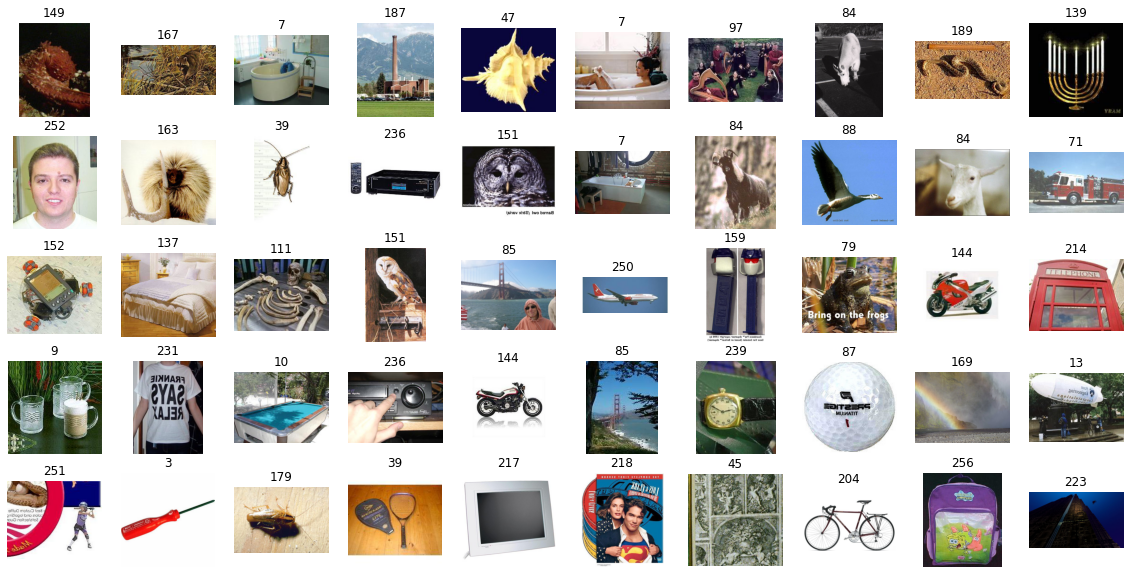

In [3]:
dataset = datasets.Caltech256(                                  # load dataset to folder data
    root = 'data',
    transform = transforms.ToTensor(), 
    download = True,            
)
print(dataset,"\ntotal images:", len(dataset))

rows, cols, i = 5, 10, 0
idx = torch.randint(high = len(dataset), size = (len(dataset),) )  
images = []
for iD in idx:
    img = dataset[iD][0].permute(1, 2, 0).numpy()        
    if img.shape[-1] == 3:                                      # remove grayscale
        images.append(img)
    if len(images) == rows*cols:
        break

plt.figure(figsize=(2*cols, 2*rows), facecolor ='w')            # draw rows*cols random images      
for row in range(rows):        
    for col in range(cols):
        ax=plt.subplot(rows, cols, i+1)                    
        plt.title(f"{dataset[idx[i]][1]}")    
        plt.imshow(images[i])  
        plt.axis("off")
        i += 1
plt.show()    

## CLIP Model

We load the CLIP model and display its structure.

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
summary(model, depth=1)

Layer (type:depth-idx)                                                 Param #
CLIP                                                                   301,569
├─VisionTransformer: 1-1                                               87,849,216
├─Transformer: 1-2                                                     37,828,608
├─Embedding: 1-3                                                       25,296,896
├─LayerNorm: 1-4                                                       1,024
Total params: 151,277,313
Trainable params: 151,277,313
Non-trainable params: 0

## Test CLIP for some images from Caltech256

The selection the set of texts is important, since `softmax` is an insidious thing. Try removing text:
- "dolphin in the sea"
- "palm tree on the beach"

torch.Size([1, 512]) torch.Size([7, 512])
+ 0.995: a nice girl
  0.003: a cat
  0.002: a dog


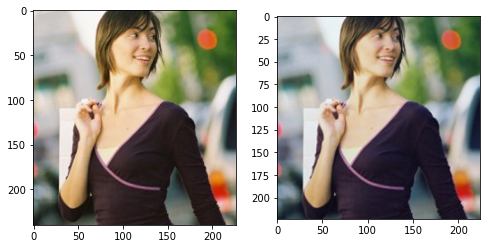

torch.Size([1, 512]) torch.Size([7, 512])
+ 0.976: palm tree on the beach
  0.024: sunset over the sea
  0.000: dolphin in the sea


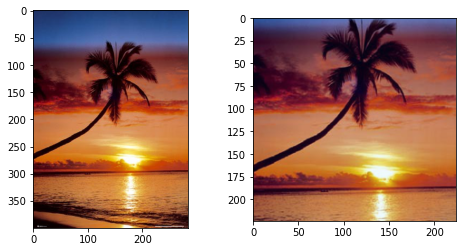

torch.Size([1, 512]) torch.Size([7, 512])
+ 0.939: a dog
  0.059: a nice girl
  0.002: a cat


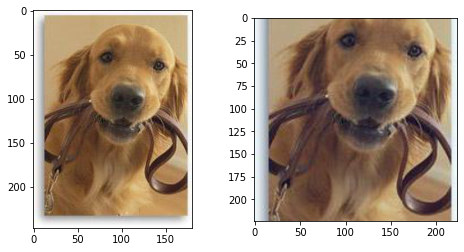

torch.Size([1, 512]) torch.Size([7, 512])
+ 1.000: dolphin in the sea
  0.000: a dog
  0.000: a cat


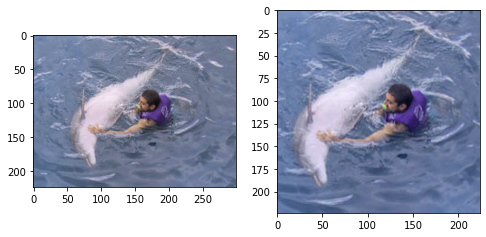

In [5]:
image_files = [
    "/content/data/caltech256/256_ObjectCategories/159.people/159_0013.jpg",
    "/content/data/caltech256/256_ObjectCategories/154.palm-tree/154_0006.jpg",
    "/content/data/caltech256/256_ObjectCategories/056.dog/056_0017.jpg",
    "/content/data/caltech256/256_ObjectCategories/057.dolphin-101/057_0020.jpg"
]
texts = [ 
    "a nice girl", 
    "a dog", 
    "a cat", 
    "fat cat eats sour cream", 
    "palm tree on the beach", 
    "sunset over the sea", 
    "dolphin in the sea", 
        ]

text = clip.tokenize(texts).to(device)

for file in image_files:
    image_orig = Image.open(file)
    image_prep = preprocess(image_orig).unsqueeze(0).to(device)   

    with torch.no_grad():
        image_features = model.encode_image(image_prep)  
        text_features  = model.encode_text(text)
    
        logits_per_image, logits_per_text = model(image_prep, text)
        probs = logits_per_image.softmax(dim=-1).float().cpu()

    print(image_features.shape, text_features.shape)  

    bests = torch.topk(probs[0], 3)                # get 3 best probabilities
    for i, Id in enumerate(bests.indices):    
        print(f"{ '+' if i==0 else ' '} {bests.values[i]:.3f}: {texts[Id]}") 

    plt.figure(figsize=(8, 4), facecolor ='w')     # plot original and preprocess images
    ax=plt.subplot(1,2,1); plt.imshow(image_orig  )
    im = image_prep[0].permute(1, 2, 0).cpu().numpy()
    ax=plt.subplot(1,2,2); plt.imshow( (im-im.min())/(im.max()-im.min()+1e-6)  )
    plt.show()

## Create a dataset with vectors and image classes

- We get all RGB pictures. 
- We get feature vectors for each of them (do not forget to normalize them and convert from half to float).

This stage takes a very long time!!!

**TODO**: create batches of images for `preprocess` and `encode_image`. This will speed up the calculations.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


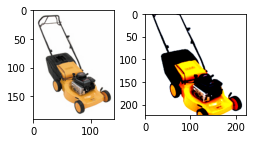

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


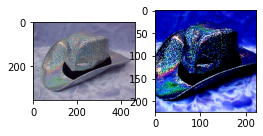

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


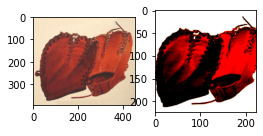

     30600      30176 (1200, 1600, 3)
 (30183, 512) 
 last vector:  [ 0.04492578  0.01200529 -0.00737836  0.01016204 -0.01920631] 
 classes:  [181, 50, 4, 231, 13, 192, 11, 128, 239, 34]


In [6]:
NUM_IMAGES = len(dataset)                                              # try to take all images except gray

idx, i, cnt = torch.randint(high = len(dataset), size = (len(dataset),) ), 0, 0
vectors = None
classes = []
while cnt < NUM_IMAGES and i < len(dataset):    
    im = dataset[idx[i]][0].permute(1, 2, 0).numpy()      
    im = (255 * (im-im.min())/(im.max()-im.min()+1e-6)).astype('uint8')
    if i and i % 100 == 0:
        print(f"\r{i:10} {cnt: 10} {im.shape}", end="")
    if im.shape[-1] == 3:    
        image_orig = Image.fromarray(im, mode='RGB')         
        image_prep = preprocess(image_orig).unsqueeze(0).to(device)   
        with torch.no_grad():
            image_features = model.encode_image(image_prep).float()      
            image_features /= image_features.norm(dim=-1, keepdim=True)   # normalize vector             
            vectors = image_features if vectors is None else torch.cat([vectors, image_features], axis=0)
            classes.append( dataset[idx[i]][1] )

        if cnt < 3:
            plt.figure(figsize=(4, 2), facecolor ='w')                    # plot original and preprocess images
            ax=plt.subplot(1,2,1); plt.imshow(image_orig  )
            im = image_prep[0].permute(1, 2, 0).cpu().numpy()
            ax=plt.subplot(1,2,2); plt.imshow( (im-im.min())/(im.max()-im.min()+1e-6)  )
            plt.imshow( im )
            plt.show()

        cnt += 1
    i += 1

vectors = vectors.cpu().numpy()
np.save("vectors", vectors)                                             # save to file vectors.npy
np.save("classes", np.array(classes)) 
print("\n",vectors.shape, "\n last vector: ", vectors[-1][:5], "\n classes: ", classes[:10])
NUM_IMAGES = len(vectors)

In [7]:
#vectors = np.load("vectors.npy")   
#classes = np.load("classes.npy")   

## Comapare

We check the quality of the features vector of the image. To do this, we calculate pairwise Euclidean distances for all images (as Google wants). For each image, we select 5 nearest neighbors. For these neighbors, we calculate the average coincidence of their classes with the class of the given image. All these values are averaged over all images.

In [8]:
from   scipy.spatial.distance import cdist

def metric(vecs, classes, neighbors=5):
    all = []
    dists = cdist(vecs, vecs)                     # pairwise Euclidean distances between vectors
    dists = -torch.tensor(dists)                  # we need minimum distances
    for i in range(len(dists)):        
        res = torch.topk(dists[i], neighbors+1)   # with himself !
        oks = sum( [classes[i] == classes[r] for r in res.indices ] ) - 1
        all.append(oks / neighbors)
    return np.mean(all)    

In [9]:
print(f"orig:{metric(vectors, classes):.3f}")     # metric of original, uncompressed vectors

orig:0.860


```
n = 30201
orig_512: 0.858
aen_64  : 0.853
pca_64  : 0.821
poo_64  : 0.791

pca_32  : 0.749
poo_32  : 0.708
```

## AverPool

In [10]:
DIM = 64

pool = nn.AdaptiveAvgPool1d((DIM,))

vectors_pool = pool(torch.tensor(vectors))
vectors_pool /= vectors_pool.norm(dim=-1, keepdim=True)   # normalize vector
vectors_pool = vectors_pool.numpy()
print(vectors_pool.shape)

print(f"pool:{metric(vectors_pool, classes):.3f}")

(30183, 64)
pool:0.793


## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=vectors.shape[1])
pca.fit(vectors)

plt.plot(pca.explained_variance_ratio_);

pca = PCA(n_components=DIM)
pca.fit(vectors)
vectors_pca = pca.transform(vectors)

vectors_pca = torch.tensor(vectors_pca)
vectors_pca /= vectors_pca.norm(dim=-1, keepdim=True)   # normalize vector
vectors_pca = vectors_pca.numpy()
print(vectors_pca.shape)

print(f"pca: {metric(vectors_pca, classes):.3f}")

## Autoencoder

In [12]:
class Autoencoder(nn.Module):
    def __init__(self,
                 inputs = 512,                                      # count of input features
                 dim    = 64,                                       # count of compress features
                 hiddens_encoder=[],                                # hiddens layers of encoder
                 hiddens_decoder=[],                                # hiddens layers of decoder
                 batchnorm = True,
                 dropout = 0):                                                        
        super(Autoencoder, self).__init__()             

        self.encoder = self.net([inputs] + hiddens_encoder + [dim],    dropout, batchnorm, True)
        self.decoder = self.net([dim]    + hiddens_decoder + [inputs], dropout, batchnorm, False)
        
        #self.model =  nn.Sequential(self.encoder, self.decoder)
 
    def net(self, hiddens, dropout, batchnorm, lastTanh):
        layers = []
        for i in range( len(hiddens)-1):            
            layers += [ nn.Linear(hiddens[i], hiddens[i+1], bias=True)]
            if batchnorm:
                layers +=  [ nn.BatchNorm1d(num_features = hiddens[i+1]) ]       
            if dropout:
                layers += [ nn.Dropout(dropout) ]                            
            if lastTanh or i < len(hiddens)- 2:
                layers += [ nn.Tanh() ]
        return nn.Sequential(*layers)       

    def forward(self, x):               
        x = self.encoder(x)
        x = x / x.norm(dim=-1, keepdim=True)        # !!!
        return self.decoder(x)

In [ ]:
CFG = {
    'encoder':   [512],
    'decoder':   [512],
    'dropout':   0.0,
    'batchnorm': True,
    'batch':     256,
    'lr':        1e-3,
    'L2':        0.0,
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

aen = Autoencoder(hiddens_encoder=CFG['encoder'], hiddens_decoder=CFG[ 'decoder'], batchnorm = CFG['batchnorm'], dropout = CFG['dropout'])
aen.to(device)

#print(aen)
summary(aen, (1,512),  col_names=["output_size", "num_params"])

### Train


In [14]:
def fit(model, X,Y, batch_size=64, train=True):         
    """ One epoch training """
    batch_size = min(batch_size, len(X))
    losses = []
    
    if train:
        idx = torch.randperm( len(X) )                  # permuted index list    
        X, Y = X[idx], Y[idx]             
    
    model.train(train)                                  # important for Dropout, BatchNorm layers
    for i in range(0, len(Y), batch_size):             
        nb = min(batch_size,  len(Y)-i)
        xb = X[i: i+nb].to(device)                      # current batch                
        yb = Y[i: i+nb].to(device) 
        
        y = model(xb)                                   # forward propagation
        L = loss(y, yb)                                 # calculate the loss        
  
        if train:                                       # we are in learning mode
            optimizer.zero_grad()                       # reset the gradients        
            L.backward()                                # calculate gradients           
            optimizer.step()                            # adjusting parameters
                                     
        losses.append(L.cpu().item())                   # total loss (item from graph)
                 
    return np.mean(losses)**0.5                          # mean loss 

def plot_train(history):
    h = np.array(history)                               # learning output
    plt.figure(figsize=(8,5), facecolor ='w')              
    ax1 = plt.subplot(1,1,1);  
    ax1.set( ylim=(0, 0.03), xlim=(0, h[-1,0]) )
    ax1.grid(color='gray', linestyle='--', alpha=0.6)
    ax2=ax1.twinx()  
    ax1.plot(h[:,0], h[:,1], "-b")   
    ax1.plot(h[:,0], h[:,2], "-g")   

    ax2.plot(h[:,0], h[:,3], ":r")   

    pars = [ f"{k:10s}: {v}\n" for k,v in CFG.items() ]
    ax1.text(h[0,0]+(h[-1,0]-h[0,0])*0.5, 0., "".join(pars), {'fontsize':12, 'fontname':'monospace'})
    plt.show()

trn: torch.Size([24146, 512]) tst:  torch.Size([6037, 512])
before:      loss: 0.078290
epoch:   100 loss: 0.015012 (0.015434) L2: 3013.570312  0.4s

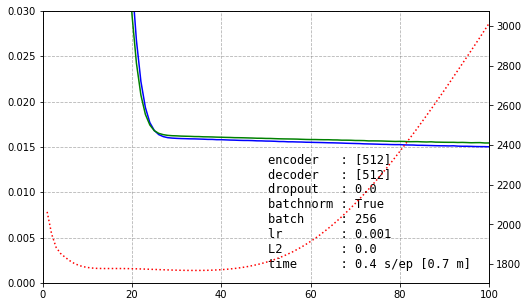

epoch:   200 loss: 0.014535 (0.015148) L2: 6564.235352  0.4s

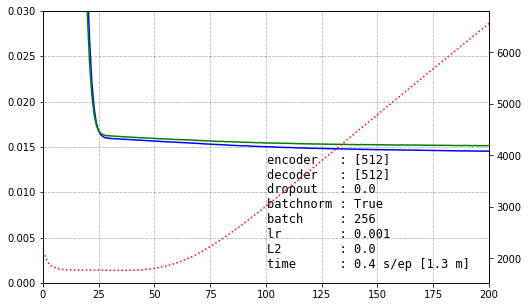

epoch:   300 loss: 0.014354 (0.015042) L2: 10018.766602  0.4s

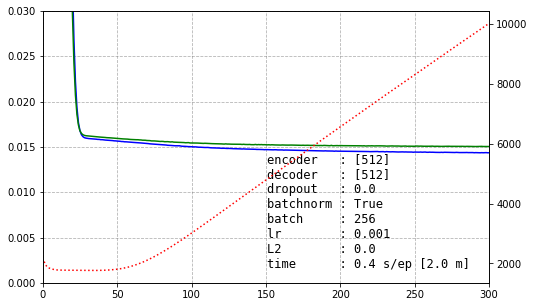

In [15]:
loss = nn.MSELoss()

optimizer = torch.optim.Adam(aen.parameters(), lr=CFG['lr'], weight_decay=CFG['L2'])   

epochs, tst_batch, TRAIN = 300, 512, 0.8

X = torch.tensor(vectors)
X = X[ torch.randint(high = len(X), size = (len(X),) )  ]
X_trn, X_tst = X[:int(len(X)*TRAIN)],  X[int(len(X)*TRAIN):]
Y_trn = torch.clone(X_trn) # ???
print("trn:", X_trn.shape, "tst: ", X_tst.shape)

aen.to(device) # just in case
L_tst = fit(aen, X_trn, Y_trn, batch_size=tst_batch, train=False)
print( f"before:      loss: {L_tst:8.6f}"  )

history,  beg, start = [],  time.process_time(), time.process_time()
for epoch in range(1, epochs+1):   
    L = fit(aen, X_trn, Y_trn, batch_size=CFG['batch'])               # train one epoch

    L_tst = fit(aen, X_tst, X_tst, batch_size=tst_batch, train=False) # test
    L2 =  sum(p.data.pow(2).sum() for p in aen.parameters()).cpu().item()

    if epoch % 1 == 0:                                                 # learning output   
        print(f"\repoch: {epoch:5d} loss: {L:8.6f} ({L_tst:8.6f}) L2: {L2:.6f}  {time.process_time()-beg:.1f}s", end="")           
        beg = time.process_time()                

    history.append([epoch, L, L_tst, L2])

    if epoch % 100  == 0 or epoch == epochs:
        CFG['time'] = f"{(time.process_time()-start)/epoch:.1f} s/ep [{(time.process_time()-start)/60:.1f} m]"
        plot_train(history)

In [16]:
batch_size = 512
aen.train(False) 
X = torch.tensor(vectors)                 # don't mix!
vectors_aen = None
for i in range(0, len(X), batch_size):             
    nb = min(batch_size,  len(X)-i)
    xb = X[i: i+nb].to(device)
    with torch.no_grad():
        y = aen.encoder(xb)             
    vectors_aen = y if vectors_aen is None else torch.cat([vectors_aen, y], axis=0)

vectors_aen /= vectors_aen.norm(dim=-1, keepdim=True) 
vectors_aen = vectors_aen.cpu().numpy()
print(vectors_aen.shape)

print(f"aen :{metric(vectors_aen, classes):.3f}")

(30183, 64)
aen :0.857


## Autoencoder Hyperparameters

```
0.855  CFG = {'encoder':[512],     'decoder':[512],     'dropout':0.0, 'batchnorm': True,  'batch':256, 'lr':1e-3, 'L2':0.0}  epochs = 200
0.854  CFG = {'encoder':[256],     'decoder':[256],     'dropout':0.0, 'batchnorm': True,  'batch':256, 'lr':1e-3, 'L2':0.0}  epochs = 200
0.850  CFG = {'encoder':[256,128], 'decoder':[128,256], 'dropout':0.0, 'batchnorm': True,  'batch':256, 'lr':1e-4, 'L2':0.0}  epochs = 1000
0.840  CFG = {'encoder':[256],     'decoder':[256],     'dropout':0.1, 'batchnorm': True,  'batch':256, 'lr':1e-3, 'L2':0.0}  epochs = 200
0.830  CFG = {'encoder':[256],     'decoder':[256],     'dropout':0.2, 'batchnorm': True,  'batch':256, 'lr':1e-3, 'L2':0.0}  epochs = 200
```
- Другой датасет, больше классов
- Аугументация, cnn-aen
- "aen" в вероятности